# Setup

### Import necessary modules and do some basic setup.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils import class_weight

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers, regularizers

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pickle
import pathlib
import hashlib
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Dotenv
from dotenv import dotenv_values

# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_resnet import *
from utils.utils_plot import *

2023-01-17 12:02:49.919726: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  2


### Define some paths and constants.

In [2]:
config = dotenv_values(".env")

# Paths
PATH_ERA5 = config['PATH_ERA5']
PATH_EOBS = config['PATH_EOBS']

# Some constants
G = 9.80665

# Options
DATE_START = '1979-01-01'
DATE_END = '2021-12-31'
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2021]
LEVELS = [300, 500, 700, 850, 925, 1000]
LONS_INPUT = [-25, 30]
LATS_INPUT = [30, 75]
LONS_PREC = [-25, 30]
LATS_PREC = [30, 75]
BATCH_SIZE = 64
PRECIP_DATA = 'E-OBS' # Options: ERA5-hi, ERA5-low, E-OBS
PRECIP_XTRM = 0.99 # Percentile (threshold) for the extremes
USE_3D_ONLY = False

# Data preparation

## Target variable: precipitation field

In [3]:
# Load precipitation
if PRECIP_DATA == 'ERA5-hi':
    pr = get_nc_data(PATH_ERA5 + '/precipitation/orig_grid/daily/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.tp
elif PRECIP_DATA == 'ERA5-low':
    pr = get_nc_data(PATH_ERA5 + '/precipitation/day_grid1/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.tp
elif PRECIP_DATA in ['E-OBS', 'EOBS']:
    pr = get_nc_data(PATH_EOBS + '/eobs_1deg_v26.0e.nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
    pr = pr.rr
    #pr = pr.fillna(0) # Over the seas. Not optimal...
else:
    raise ValueError('Precipitation data not well defined')

Extracting data for the period 1979-01-01 - 2021-12-31


In [4]:
# Add a dimension to be used as channel in the DNN
pr = pr.expand_dims('level', -1)
pr

<xarray.DataArray 'rr' (time: 15706, lat: 46, lon: 56, level: 1)>
dask.array<transpose, shape=(15706, 46, 56, 1), dtype=float32, chunksize=(15706, 46, 56, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2021-12-31
  * lon      (lon) float64 -25.0 -24.0 -23.0 -22.0 -21.0 ... 27.0 28.0 29.0 30.0
  * lat      (lat) float64 30.0 31.0 32.0 33.0 34.0 ... 71.0 72.0 73.0 74.0 75.0
Dimensions without coordinates: level
Attributes:
    standard_name:  thickness_of_rainfall_amount
    long_name:      rainfall
    units:          mm
    cell_methods:   time: mean

In [5]:
# Compute the extreme exceedence
qq = xr.DataArray(pr).quantile(PRECIP_XTRM, dim='time')
pr_xtrm = xr.DataArray(pr > qq)
pr_xtrm = pr_xtrm*1 # Transform to number

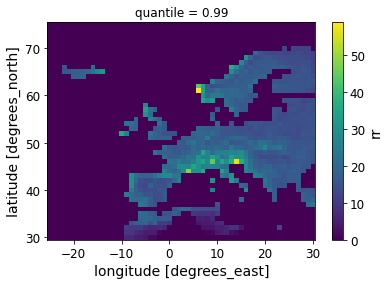

In [6]:
qq.plot()

In [7]:
# Extract coordinates for precip
lats_y = pr.lat.to_numpy()
lons_y = pr.lon.to_numpy()

In [33]:
xxy = pr[plot_date,:,:,0]

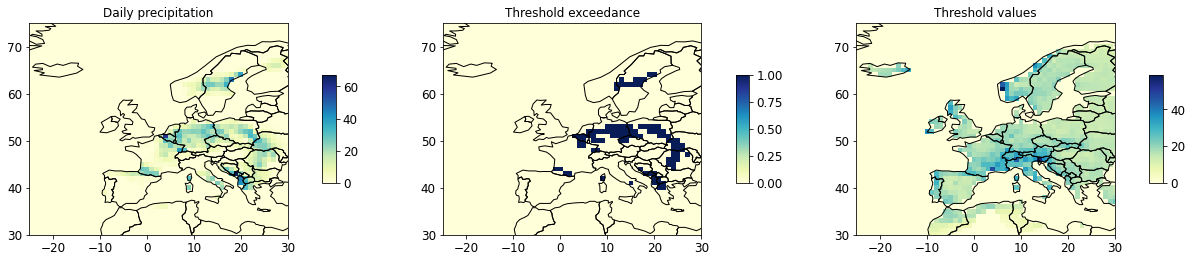

In [36]:
# Get the date with the max number of grid points with pr > threshold
x = pr_xtrm.sum(dim=['lat', 'lon'])
plot_date = x.argmax(dim='time')

# Plot precip, threshold exceedance and threshold values
fig, axs = plt.subplots(1, 3, figsize=(21,4))

if PRECIP_DATA in ['E-OBS', 'EOBS']:
    pp = pr[plot_date,:,:,0]
    px = pr_xtrm[plot_date,:,:,0]
else:
    pp = pr[plot_date,:,:]
    px = pr_xtrm[plot_date,:,:]

plot_map(axs[0], lons_y, lats_y, pp.to_numpy().squeeze(), title="Daily precipitation", cmap=mpl.cm.YlGnBu)
plot_map(axs[1], lons_y, lats_y, px.to_numpy().squeeze(), title="Threshold exceedance", cmap=mpl.cm.YlGnBu)
plot_map(axs[2], lons_y, lats_y, qq.to_numpy().squeeze(), title="Threshold values", cmap=mpl.cm.YlGnBu)

## Input data: meteorological fields

In [11]:
# Load geopotential height
z = get_era5_data(PATH_ERA5 + '/geopotential/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
z['time'] = pd.DatetimeIndex(z.time.dt.date)
z = z.sel(level=LEVELS)

# Get Z in geopotential height (m)
z.z.values = z.z.values/G

# Load temperature
t = get_era5_data(PATH_ERA5 + '/temperature/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
t['time'] = pd.DatetimeIndex(t.time.dt.date)

# Load relative humidity
rh = get_era5_data(PATH_ERA5 + '/relative_humidity/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
rh['time'] = pd.DatetimeIndex(rh.time.dt.date)
rh = rh.sel(level=LEVELS)

# Load total column water
if not USE_3D_ONLY:
    tcw = get_era5_data(PATH_ERA5 + '/total_column_water/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    tcw['time'] = pd.DatetimeIndex(tcw.time.dt.date)

# Load wind components
u = get_era5_data(PATH_ERA5 + '/U_wind/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
u['time'] = pd.DatetimeIndex(u.time.dt.date)
v = get_era5_data(PATH_ERA5 + '/V_wind/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
v['time'] = pd.DatetimeIndex(v.time.dt.date)

# Checking dimensions
print('dimension of pr:', pr.dims)
print('dimension of z', z.dims)
print('dimension of t:', t.dims)
print('dimension of rh:', rh.dims)
if not USE_3D_ONLY:
    print('dimension of tcw:', tcw.dims)
print('dimension of u:', u.dims)
print('dimension of v:', v.dims)


Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
dimension of pr: ('time', 'lat', 'lon', 'level')
dimension of z Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})
dimension of t: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})
dimension of rh: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})
dimension of tcw: Frozen({'time': 15706, 'lon': 56, 'lat': 46})
dimension of u: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})
dimension of v: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})


In [12]:
# Merge arrays
if USE_3D_ONLY:
    X = xr.merge([z, t, rh, u, v])
else:
    X = xr.merge([z, t, rh, tcw, u, v])
X

,Array,Chunk
Bytes,0.90 GiB,21.58 MiB
Shape,"(15706, 6, 46, 56)","(366, 6, 46, 56)"
Count,258 Tasks,43 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,0.90 GiB,21.58 MiB
Shape,"(15706, 6, 46, 56)","(366, 6, 46, 56)"
Count,258 Tasks,43 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [13]:
# Invert lat axis if needed
if X.lat[0].values < X.lat[1].values:
    X = X.reindex(lat=list(reversed(X.lat)))
    
# Get axes
lats_x = X.lat
lons_x = X.lon

### Split data and transform

In [14]:
# Split into training and test
X_train_full = X.sel(time=slice(f'{YY_TRAIN[0]}-01-01', f'{YY_TRAIN[1]}-12-31'))
X_test = X.sel(time=slice(f'{YY_TEST[0]}-01-01', f'{YY_TEST[1]}-12-31'))

pr_train_full = pr.sel(time=slice(f'{YY_TRAIN[0]}-01-01', f'{YY_TRAIN[1]}-12-31'))
pr_test = pr.sel(time=slice(f'{YY_TEST[0]}-01-01', f'{YY_TEST[1]}-12-31'))

pr_xtrm_train_full = pr_xtrm.sel(time=slice(f'{YY_TRAIN[0]}-01-01', f'{YY_TRAIN[1]}-12-31'))
pr_xtrm_test = pr_xtrm.sel(time=slice(f'{YY_TEST[0]}-01-01', f'{YY_TEST[1]}-12-31'))

In [15]:
# Create a data generator
if USE_3D_ONLY:
    dic = {'z': LEVELS,
       't': LEVELS,
       'r': LEVELS,
       'u': LEVELS,
       'v': LEVELS}
else:
    dic = {'z': LEVELS,
       't': LEVELS,
       'r': LEVELS,
       'tcwv': None,
       'u': LEVELS,
       'v': LEVELS}

from utils.utils_ml import *

YY_VALID = 2005

dg_train = DataGeneratorWithExtremes(X_train_full.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                     pr_train_full.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                     pr_xtrm_train_full.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                     dic, batch_size=BATCH_SIZE, load=True)
dg_valid = DataGeneratorWithExtremes(X_train_full.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                     pr_train_full.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                     pr_xtrm_train_full.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                     dic, mean=dg_train.mean, std=dg_train.std,
                                     batch_size=BATCH_SIZE, load=True)
dg_test = DataGeneratorWithExtremes(X_test, pr_test, pr_xtrm_test, dic,
                                    mean=dg_train.mean, std=dg_train.std,
                                    batch_size=BATCH_SIZE, load=True, shuffle=False)


Loading data into RAM
Loading data into RAM
Loading data into RAM


In [16]:
i_shape = dg_train.X.shape[1:]
o_shape = dg_train.y.shape[1:]

print(f'X shape: {i_shape}')
print(f'y shape: {o_shape}')

X shape: (46, 56, 31)
y shape: (46, 56, 1)


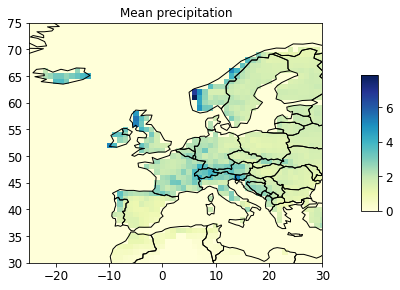

In [17]:
# Plotting the mean precipitation
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1, 1, 1)
vals = np.mean(dg_train.y, axis=0).squeeze()
plot_map(ax, lons_y, lats_y, vals, title="Mean precipitation", cmap=mpl.cm.YlGnBu)

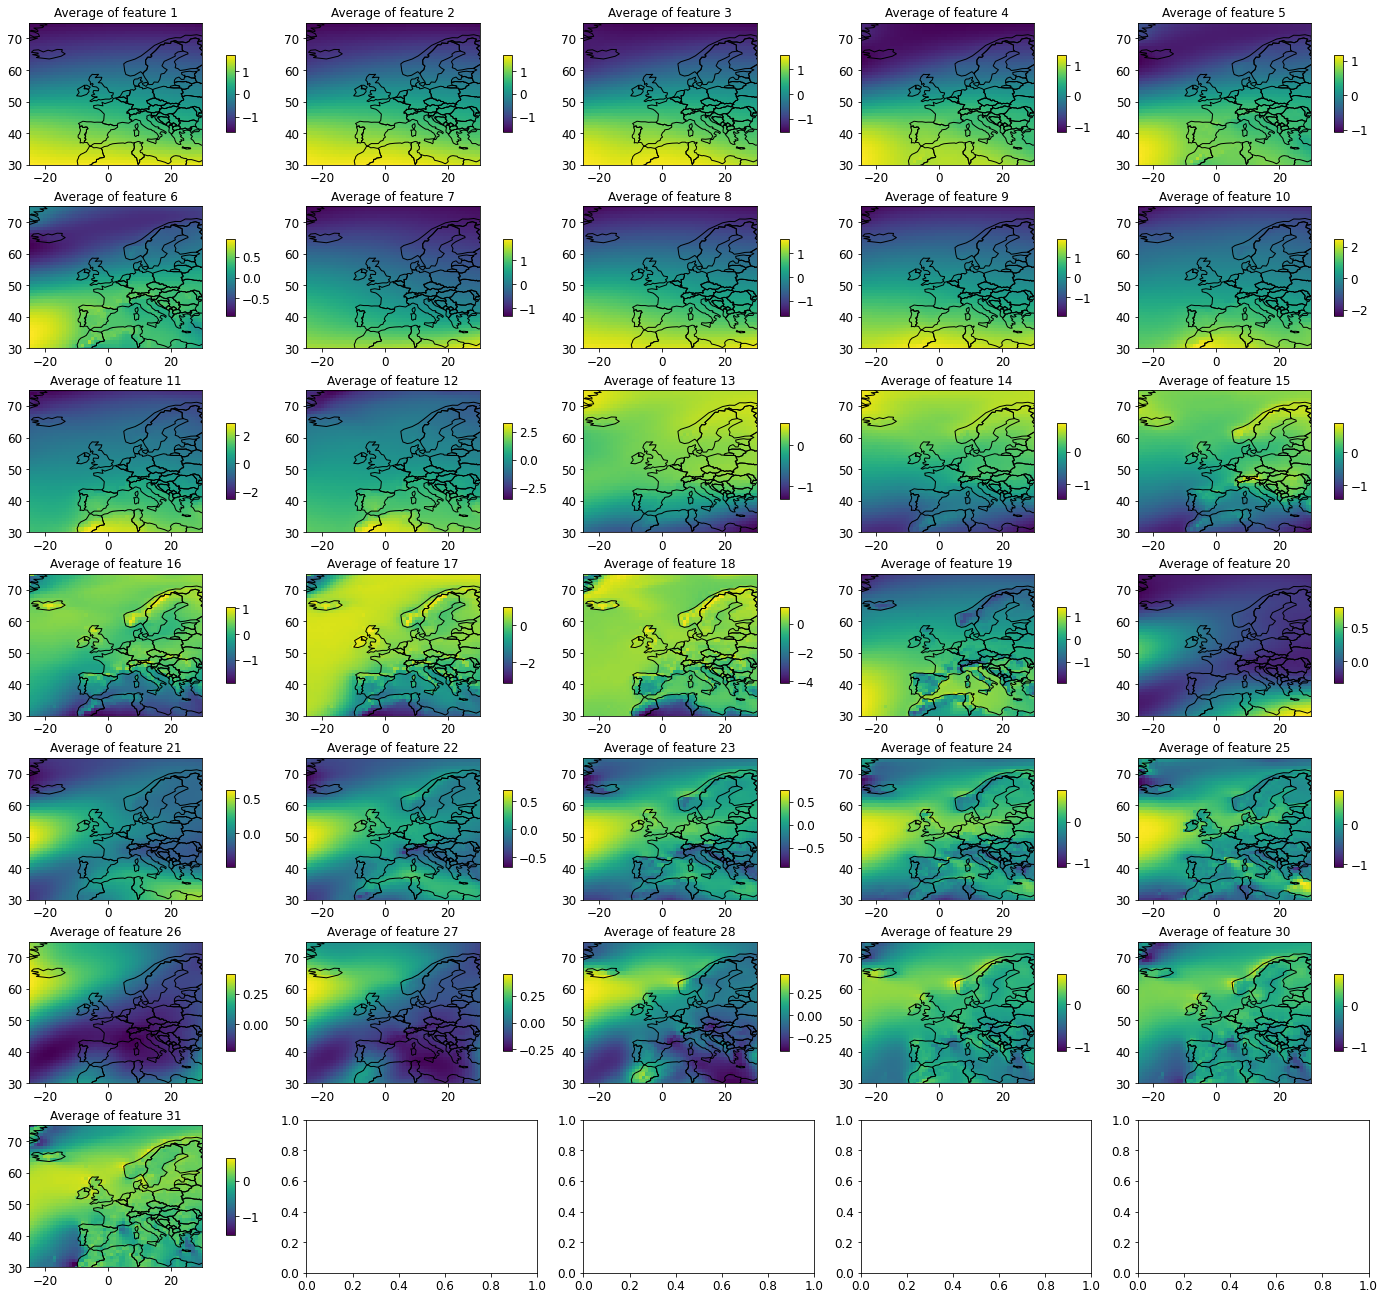

In [18]:
# Plotting the mean of the predictors
n_figs = len(dg_train.X[0,0,0,:])
ncols = 5
nrows = -(-n_figs // ncols)
fig, axes = plt.subplots(figsize=(24, 3.3*nrows), ncols=ncols, nrows=nrows)
for i in range(n_figs):
    i_row = i // ncols
    i_col = i % ncols
    ax = axes[i_row, i_col]
    vals = np.mean(dg_train.X[:,:,:,i], axis=0).to_numpy()
    plot_map(ax, lons_x, lats_x, vals, title=f"Average of feature {i+1}")

# Model creation

In [19]:
class DeepFactory(tf.keras.Model):
    """
    Model factory.
    """

    def __init__(self, arch, input_size, output_size, for_extremes=False, latent_dim=128, 
                 dropout_rate=0.2, use_batch_norm=True, inner_activation='relu', unet_filters_nb=64, 
                 unet_depth=4, use_upsample=False, output_scaling=1, output_crop=None, levels_nb_3d=6):
        super(DeepFactory, self).__init__()
        self.arch = arch
        self.input_size = list(input_size)
        self.output_size = list(output_size)
        self.for_extremes = for_extremes
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.use_upsample = use_upsample
        self.inner_activation = inner_activation
        self.unet_depth = unet_depth
        self.unet_filters_nb = unet_filters_nb
        self.output_scaling = output_scaling
        self.output_crop = output_crop
        self.levels_nb_3d = levels_nb_3d
        
        self.last_activation = 'relu'
        if for_extremes:
            self.last_activation = 'sigmoid'

        if arch == 'Davenport-2021':
            self.build_Davenport_2021()
        elif arch == 'CNN-2L':
            self.build_CNN_2L()
        elif arch == 'Unet':
            self.build_Unet()
        elif arch == 'Unet-attention':
            self.build_UnetAtt()
        elif arch == 'Pan-2019':
            self.build_Pan_2019()
        elif arch =='Conv-LTSM':
            self.build_convLTSM()
        elif arch =='RaNet':
            self.build_RaNet()
        else:
            raise ValueError('The architecture was not correctly defined')
        
        
    def build_Davenport_2021(self):
        """
        Based on: Davenport, F. V., & Diffenbaugh, N. S. (2021). Using Machine Learning to 
        Analyze Physical Causes of Climate Change: A Case Study of U.S. Midwest Extreme Precipitation. 
        Geophysical Research Letters, 48(15). https://doi.org/10.1029/2021GL093787
        """
        
        # Downsampling
        inputs = layers.Input(shape=self.input_size)
        x = layers.Conv2D(16, 3, padding='same', activity_regularizer=regularizers.l2(0.01))(inputs)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.SpatialDropout2D(self.dropout_rate)(x) # In original: simple Dropout
        x = layers.Conv2D(16, 3, padding='same', activity_regularizer=regularizers.l2(0.01))(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.SpatialDropout2D(self.dropout_rate)(x) # In original: simple Dropout
        x = layers.Flatten()(x)                
        x = layers.Dense(self.latent_dim, activity_regularizer=regularizers.l2(0.001))(x) # In original: 16
        x = layers.Activation('relu')(x)

        next_shape = self.get_shape_for(stride_factor=4)

        # Upsampling. In original: no decoder
        x = self.dense_block(x, np.prod(next_shape))
        x = layers.Reshape(target_shape=next_shape)(x)
        x = self.deconv_block(x, 16, 3, stride=2)
        x = self.deconv_block(x, 16, 3, stride=2)
        x = self.conv_block(x, 1, 3, activation=self.last_activation)
        outputs = self.final_cropping_block(x)
 
        self.model = keras.Model(inputs, outputs, name="Davenport-2021")
        
        
    def build_Pan_2019(self):
        """
        Based on: Pan, B., Hsu, K., AghaKouchak, A., & Sorooshian, S. (2019). 
        Improving Precipitation Estimation Using Convolutional Neural Network. 
        Water Resources Research, 55(3), 2301–2321. https://doi.org/10.1029/2018WR024090
        """
        # In original: padding='valid'
        
        # Downsampling
        inputs = layers.Input(shape=self.input_size)
        x = layers.Conv2D(15, 4, padding='same')(inputs)
        x = layers.Activation('relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(20, 4, padding='same')(x)
        x = layers.Activation('relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Conv2D(20, 4, padding='same')(x)
        x = layers.Activation('relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Flatten()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(self.latent_dim, activation='relu')(x) # In original: 60

        next_shape = self.get_shape_for(stride_factor=4)

        # Upsampling. In original: no decoder
        x = self.dense_block(x, np.prod(next_shape))
        x = layers.Reshape(target_shape=next_shape)(x)
        x = self.deconv_block(x, 20, 4, stride=2)
        x = self.deconv_block(x, 20, 4, stride=2)
        x = self.conv_block(x, 15, 4)
        x = self.conv_block(x, 1, 3, activation=self.last_activation)
        outputs = self.final_cropping_block(x)

        self.model = keras.Model(inputs, outputs, name="Pan-2019")


    def build_CNN_2L(self):

        # Downsampling
        inputs = layers.Input(shape=self.input_size)
        x = self.conv_block(inputs, 32, 3, stride=2, with_batchnorm=True, with_dropout=True)
        x = self.conv_block(x, 64, 3, stride=2, with_batchnorm=True, with_dropout=True)
        x = layers.Flatten()(x)
        x = self.dense_block(x, self.latent_dim, activation='sigmoid')

        next_shape = self.get_shape_for(stride_factor=4)

        # Upsampling
        x = self.dense_block(x, np.prod(next_shape))
        x = layers.Reshape(target_shape=next_shape)(x)
        x = self.deconv_block(x, 64, 3, stride=2)
        x = self.deconv_block(x, 32, 3, stride=2)
        x = self.deconv_block(x, 1, 3, activation=self.last_activation)
        outputs = self.final_cropping_block(x)

        self.model = keras.Model(inputs, outputs, name="CNN-v1")
        

    def build_convLTSM(self):
        
        expanded_shape = self.input_size.copy()
        expanded_shape.insert(0, 1)
        
        inputs = layers.Input(shape=self.input_size)
        
        x = layers.Reshape(target_shape=expanded_shape)(inputs)
        
        x = layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=True, padding = 'same',
                              go_backwards=True, activation='tanh',
                              dropout=0.4, recurrent_dropout=0.2)(x)
        x = layers.BatchNormalization()(x)

        x = layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), return_sequences=True, padding = 'same',
                              go_backwards=True, activation='tanh',
                              dropout=0.4, recurrent_dropout=0.2)(x)
        x = layers.BatchNormalization()(x)

        x = layers.ConvLSTM2D(filters=8, kernel_size=(3, 3), return_sequences=False, padding = 'same',
                              go_backwards=True, activation='tanh',
                              dropout=0.3, recurrent_dropout=0.2)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters=16, kernel_size=(1, 1), activation='relu')(x)

        x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
        #model.add(Flatten())
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Conv2DTranspose(filters=1, kernel_size=(1, 1), strides=(2, 2),  activation='sigmoid',
                                   padding='same')(x)

        outputs = self.final_cropping_block(x)

        self.model = keras.Model(inputs, outputs, name="Conv-LTSM")
        
        
    def build_Unet(self):
        """
        Based on: U-Net: https://github.com/nikhilroxtomar/Unet-for-Person-Segmentation/blob/main/model.py
        """
        
        # Downsampling
        inputs = layers.Input(shape=self.input_size)
        
        # Pad if necessary
        x = self.padding_block(inputs, factor=2**self.unet_depth)
        
        skips = []
        for i in range(self.unet_depth):
            s, x = self.unet_encoder_block(x, self.unet_filters_nb * 2**i)
            skips.append(s)
        
        x = self.conv_block(x, self.unet_filters_nb * 2**self.unet_depth, 3, initializer='he_normal', with_batchnorm=True, with_dropout=True)
        x = self.conv_block(x, self.unet_filters_nb * 2**self.unet_depth, 3, initializer='he_normal', with_batchnorm=True)

        # Upsampling
        for i in reversed(range(self.unet_depth)):
            x = self.unet_decoder_block(x, skips[i], self.unet_filters_nb * 2**i, is_last=(i==0))
        
        # Additional upsampling for downscaling
        x = self.handle_output_scaling(x)

        x = self.conv_block(x, 1, 1, activation=self.last_activation)
        outputs = self.final_cropping_block(x)

        self.model = keras.Model(inputs, outputs, name="U-Net-v1")
                
            
    def build_UnetAtt(self):
        """
        U-Net with attention mechanism
        """
        
        # Downsampling
        inputs = layers.Input(shape=self.input_size)
        
        # Pad if necessary
        x = self.padding_block(inputs, factor=self.unet_depth**2)
        
        skips = []
        for i in range(self.unet_depth):
            s, x = self.unet_encoder_block(x, self.unet_filters_nb * 2**i)
            skips.append(s)
        
        x = self.conv_block(x, self.unet_filters_nb * 2**self.unet_depth, 3, initializer='he_normal', with_batchnorm=True, with_dropout=True)
        x = self.conv_block(x, self.unet_filters_nb * 2**self.unet_depth, 3, initializer='he_normal', with_batchnorm=True)

        # Upsampling
        for i in reversed(range(self.unet_depth)):
            x = self.unet_decoder_block_attention(x, skips[i], self.unet_filters_nb * 2**i, is_last=(i==0))
        
        # Additional upsampling for downscaling
        x = self.handle_output_scaling(x)

        x = self.conv_block(x, 1, 1, activation=self.last_activation)
        outputs = self.final_cropping_block(x)

        self.model = keras.Model(inputs, outputs, name="U-Net-attention")
        
        
    def build_RaNet(self):
        """
        Based on: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL090309
        """
        
        expanded_shape = self.input_size.copy()
        expanded_shape.insert(len(expanded_shape), int(expanded_shape[-1]/self.levels_nb_3d))
        expanded_shape[-2] = self.levels_nb_3d
        
        print(f"New shape: {expanded_shape}")
        
        inputs = layers.Input(shape=self.input_size)
        x = layers.Reshape(target_shape=expanded_shape)(inputs)
        
        n_filters = 64
        
        # Downsampling
        
        #x = self.conv_block(inputs, 32, 3, stride=2, with_batchnorm=True, with_dropout=True)
        #x = self.conv_block(x, 64, 3, stride=2, with_batchnorm=True, with_dropout=True)
        
        x = layers.Conv3D(n_filters, kernel_size=(3, 3, 3),padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling3D()(x)
        x = layers.Conv3D(n_filters*2, kernel_size=(3, 3, 3),padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling3D()(x)
        x = layers.Conv3D(n_filters*4, kernel_size=(3, 3, 3),padding="same")(x)

        x = layers.GlobalAveragePooling3D()(x)
        x = layers.Dense(n_filters*4, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(n_filters*8, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(n_filters*4, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        
        next_shape = self.get_shape_for(stride_factor=4)

        # Upsampling.
        x = self.dense_block(x, np.prod(next_shape))
        x = layers.Reshape(target_shape=next_shape)(x)
        x = self.deconv_block(x, n_filters*4, 3, stride=2)
        x = self.deconv_block(x, n_filters*2, 3, stride=2)
        x = self.deconv_block(x, n_filters, 3, stride=2)
        x = self.conv_block(x, 1, 3, activation=self.last_activation)
        outputs = self.final_cropping_block(x)
        
        # Additional upsampling for downscaling
        x = self.handle_output_scaling(x)

        x = self.conv_block(x, 1, 1, activation=self.last_activation)
        outputs = self.final_cropping_block(x)

        self.model = keras.Model(inputs, outputs, name="RaNet")
        
        
    def unet_encoder_block(self, input, filters, kernel_size=3):
        x = self.conv_block(input, filters, kernel_size, initializer='he_normal', with_batchnorm=True, with_dropout=True)
        x = self.conv_block(x, filters, kernel_size, initializer='he_normal', with_batchnorm=True)
        p = layers.MaxPooling2D((2, 2))(x)
        
        return x, p

    
    def unet_decoder_block(self, input, skip_features, filters, conv_kernel_size=3, deconv_kernel_size=2, is_last=False):
        x = self.deconv_block(input, filters, deconv_kernel_size, stride=2)
        x = layers.Concatenate()([x, skip_features])
        x = self.conv_block(x, filters, conv_kernel_size, initializer='he_normal', with_batchnorm=True, with_dropout=True)
        x = self.conv_block(x, filters, conv_kernel_size, initializer='he_normal', with_batchnorm=(not is_last))

        return x
        
        
    def unet_decoder_block_attention(self, input, skip_features, filters, conv_kernel_size=3, deconv_kernel_size=2, is_last=False):
        x = attention_up_and_concate(input, skip_features)
        x = self.conv_block(x, filters, conv_kernel_size, initializer='he_normal', with_batchnorm=True, with_dropout=True)
        x = self.conv_block(x, filters, conv_kernel_size, initializer='he_normal', with_batchnorm=(not is_last))

        return x
        
        
    def conv_block(self, input, filters, kernel_size=3, stride=1, padding='same', initializer='default', activation='default', 
                   with_batchnorm=False, with_pooling=False, with_dropout=False, with_late_activation=False):
        if activation == 'default':
            activation = self.inner_activation
            
        conv_activation = activation
        if with_late_activation:
            conv_activation = None
            
        if initializer == 'default':
            x = layers.Conv2D(filters, kernel_size, strides=(stride, stride), padding=padding, activation=conv_activation)(input)
        else:
            x = layers.Conv2D(filters, kernel_size, strides=(stride, stride), padding=padding, activation=conv_activation, kernel_initializer=initializer)(input)
            
        if with_batchnorm:
            x = layers.BatchNormalization()(x)
        if with_late_activation:
            x = layers.Activation(activation)(x)
        if with_pooling:
            x = layers.MaxPooling2D(pool_size=2)(x)
        if with_dropout:
            x = layers.SpatialDropout2D(self.dropout_rate)(x)
        
        return x
    
    
    def deconv_block(self, input, filters, kernel_size=3, stride=1, padding='same', initializer='default', activation='default', 
                     with_batchnorm=False, with_dropout=False):
        if activation == 'default':
            activation = self.inner_activation
        
        if self.use_upsample:
            x = layers.UpSampling2D((2, 2))(input)
        else:
            if initializer == 'default':
                x = layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding=padding, activation=activation)(input)
            else:
                x = layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding=padding, activation=activation, kernel_initializer=initializer)(input)
            
        if with_batchnorm:
            x = layers.BatchNormalization()(x)
        if with_dropout:
            x = layers.SpatialDropout2D(self.dropout_rate)(x)
        
        return x
    
    
    def dense_block(self, input, units, activation='default', with_dropout=False):
        if activation == 'default':
            activation=self.inner_activation
            
        x = layers.Dense(units, activation=activation)(input)
        if with_dropout:
            x = layers.Dropout(self.dropout_rate)(x)
            
        return x

    
    def handle_output_scaling(self, input, with_batchnorm=False):
        if self.output_scaling > 1:
            if self.output_scaling == 2:
                x = self.deconv_block(input, 64, 3, stride=2, with_batchnorm=with_batchnorm)
            elif self.output_scaling == 3:
                x = self.deconv_block(input, 64, 3, stride=3, with_batchnorm=with_batchnorm)
            elif self.output_scaling == 4:
                x = self.deconv_block(input, 64, 3, stride=2, with_batchnorm=with_batchnorm)
                x = self.deconv_block(x, 64, 3, stride=2, with_batchnorm=with_batchnorm)
            elif self.output_scaling == 5:
                x = self.deconv_block(input, 64, 3, stride=3, with_batchnorm=with_batchnorm)
                x = self.deconv_block(x, 64, 3, stride=2, with_batchnorm=with_batchnorm)
            else:
                raise NotImplementedError('Level of downscaling not implemented')
        else:
            x = input
        
        if self.output_crop:
            raise NotImplementedError('Manual cropping not yet implemented')
            
        return x
            
        
    def padding_block(self, x, factor):
        h, w = x.get_shape().as_list()[1:3]
        dh = 0
        dw = 0
        if h % factor > 0:
            dh = factor - h % factor
        if w % factor > 0:
            dw = factor - w % factor
        if dh > 0 or dw > 0:
            top_pad = dh//2
            bottom_pad = dh//2 + dh%2
            left_pad = dw//2
            right_pad = dw//2 + dw%2
            x = layers.ZeroPadding2D(padding=((top_pad, bottom_pad), (left_pad, right_pad)))(x)
        
        return x
        
        
    def final_cropping_block(self, x):
        # Compute difference between reconstructed width and hight and the desired output size.
        h, w = x.get_shape().as_list()[1:3]
        h_tgt, w_tgt = self.output_size[:2]
        dh = h - h_tgt
        dw = w - w_tgt

        if dh < 0 or dw < 0:
            raise ValueError(f'Negative values in output cropping dh={dh} and dw={dw}')

        # Add to decoder cropping layer and final reshaping
        x = layers.Cropping2D(cropping=((dh//2, dh-dh//2), (dw//2, dw-dw//2)))(x)
        #x = layers.Reshape(target_shape=self.output_size,)(x)
        
        return x
        

    def get_shape_for(self, stride_factor):
        next_shape = self.output_size.copy()
        next_shape[0] = int(np.ceil(next_shape[0]/stride_factor))
        next_shape[1] = int(np.ceil(next_shape[1]/stride_factor))

        return next_shape

        
    def call(self, x):
        return self.model(x)
    


In [20]:
# Computing the necessary output scaling.
dlons_x = float(lons_x[1] - lons_x[0])
dlats_x = float(lats_x[0] - lats_x[1])
dlons_y = float(lons_y[1] - lons_y[0])
dlats_y = float(lats_y[0] - lats_y[1])

output_scaling = int(dlons_x / dlons_y)
output_crop = None

In [21]:
def initiate_optimizer(lr_method, lr=.0004, init_lr=0.01, max_lr=0.01):
    if lr_method == 'Cyclical':
        # Cyclical learning rate
        steps_per_epoch = dg_train.n_samples // BATCH_SIZE
        clr = tfa.optimizers.CyclicalLearningRate(
            initial_learning_rate=init_lr,
            maximal_learning_rate=max_lr,
            scale_fn=lambda x: 1/(2.**(x-1)),
            step_size=2 * steps_per_epoch)
        optimizer = tf.keras.optimizers.Adam(clr)
    elif lr_method == 'CosineDecay':
        decay_steps = EPOCHS * (dg_train.n_samples / BATCH_SIZE)
        lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
            init_lr, decay_steps)
        optimizer = tf.keras.optimizers.Adam(lr_decayed_fn)
    elif lr_method == 'Constant':
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    else:
        raise ValueError('learning rate schedule not well defined.')
        
    return optimizer

In [22]:
# Compute weights for the weighted binary crossentropy
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(pr_xtrm.values),
    y=pr_xtrm.values.flatten()
)

print('Weights for the weighted binary crossentropy:')
print(f'Classes: {np.unique(pr_xtrm.values)}, weights: {weights}')

# Create loss function for the extremes
xtrm_loss = weighted_binary_cross_entropy(
    weights={0: weights[0].astype('float32'), 1: weights[1].astype('float32')})

Weights for the weighted binary crossentropy:
Classes: [0 1], weights: [  0.50153642 163.21608494]


In [23]:
def analyze_predictions(y_pred, dg, qq, pred_xtrm=False, show_plots=True, plot_most_extreme=True, plot_worst_best=False, plot_scores=True, plot_confusion_components=True):
    if pred_xtrm:
        y_pred_bool = y_pred >= 0.5
    else:
        y_pred_bool = y_pred > qq.to_numpy().squeeze()
        
    # Multiply to transorm to numeric values
    y_pred_bool = y_pred_bool * 1
    
    # Extract true values
    y_xtrm = dg.y_xtrm.to_numpy().squeeze()
    y_prec = dg.y.to_numpy().squeeze()
    
    # Get the index of the max # of extremes
    i_max_obs = np.argmax(np.sum(y_xtrm, axis=(1,2)))
    
    if show_plots and plot_most_extreme:
        if pred_xtrm:
            fig, axes = plt.subplots(figsize=(12, 3.5), ncols=2, nrows=1)
            plot_map(axes[0], lons_y, lats_y, y_xtrm[i_max_obs], title="Day with max # extremes - truth (xtrm)", vmin=0, vmax=1)
            plot_map(axes[1], lons_y, lats_y, y_pred[i_max_obs], title="Day with max # extremes - prediction (prob xtrm)", vmin=0, vmax=1)
        else:
            fig, axes = plt.subplots(figsize=(24, 3.5), ncols=4, nrows=1)
            vmax = max(np.max(y_prec[i_max_obs]), np.max(y_pred[i_max_obs]))
            plot_map(axes[0], lons_y, lats_y, y_prec[i_max_obs], title="Day with max # extremes - truth (val)", vmin=0, vmax=vmax)
            plot_map(axes[1], lons_y, lats_y, y_pred[i_max_obs], title="Day with max # extremes - prediction (val)", vmin=0, vmax=vmax)
            plot_map(axes[2], lons_y, lats_y, y_xtrm[i_max_obs], title="Day with max # extremes - truth (xtrm)", vmin=0, vmax=1)
            plot_map(axes[3], lons_y, lats_y, y_pred_bool[i_max_obs], title="Day with max # extremes - prediction (xtrm)", vmin=0, vmax=1)
        
    # Get the index of the max/min difference between prediction and obs
    y_diffs_series = np.sum(np.absolute(y_xtrm - y_pred_bool), axis=(1,2))
    i_worst_pred = np.argmax(y_diffs_series)
    i_best_pred = np.argmin(y_diffs_series)
    
    if show_plots and plot_worst_best:
        if pred_xtrm:
            fig, axes = plt.subplots(figsize=(24, 3.5), ncols=4, nrows=1)
            plot_map(axes[0], lons_y, lats_y, y_xtrm[i_worst_pred], title="Worst prediction - truth", vmin=0, vmax=1)
            plot_map(axes[1], lons_y, lats_y, y_pred[i_worst_pred], title="Worst prediction - prediction", vmin=0, vmax=1)
            plot_map(axes[2], lons_y, lats_y, y_xtrm[i_best_pred], title="Best prediction - truth", vmin=0, vmax=1)
            plot_map(axes[3], lons_y, lats_y, y_pred[i_best_pred], title="Best prediction - prediction", vmin=0, vmax=1)
        else:
            fig, axes = plt.subplots(figsize=(24, 3.5), ncols=4, nrows=1)
            plot_map(axes[0], lons_y, lats_y, y_xtrm[i_worst_pred], title="Worst prediction - truth", vmin=0, vmax=1)
            plot_map(axes[1], lons_y, lats_y, y_pred_bool[i_worst_pred], title="Worst prediction - prediction", vmin=0, vmax=1)
            plot_map(axes[2], lons_y, lats_y, y_xtrm[i_best_pred], title="Best prediction - truth", vmin=0, vmax=1)
            plot_map(axes[3], lons_y, lats_y, y_pred_bool[i_best_pred], title="Best prediction - prediction", vmin=0, vmax=1)
    
    # Compute scores
    precision, recall = eval_confusion_matrix_scores_on_map(y_xtrm, y_pred_bool)

    if pred_xtrm:
        roc_auc = eval_roc_auc_score_on_map(y_xtrm, y_pred)
        
    if show_plots and plot_scores:
        if pred_xtrm:
            fig, axes = plt.subplots(figsize=(18, 4), ncols=3, nrows=1)
        else:
            fig, axes = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)

        plot_map(axes[0], lons_y, lats_y, precision, title="Precision", vmin=0, vmax=1)
        plot_map(axes[1], lons_y, lats_y, recall, title="Recall", vmin=0, vmax=1)
        if pred_xtrm:
            plot_map(axes[2], lons_y, lats_y, roc_auc, title="ROC AUC", vmin=0.5, vmax=1)

    if show_plots and plot_confusion_components:
        tn, fp, fn, tp = eval_confusion_matrix_on_map(y_xtrm, y_pred_bool)
        fig, axes = plt.subplots(figsize=(24, 4), ncols=4, nrows=1)
        plot_map(axes[0], lons_y, lats_y, tn, title="True negative")
        plot_map(axes[1], lons_y, lats_y, fp, title="False positive")
        plot_map(axes[2], lons_y, lats_y, fn, title="False negative")
        plot_map(axes[3], lons_y, lats_y, tp, title="True positive")
    
    plt.show()
    
    if pred_xtrm:
        return np.mean(precision), np.mean(recall), np.mean(roc_auc)
    
    return np.mean(precision), np.mean(recall)

In [24]:
# Define hyperparameters
EPOCHS = 200
LR_METHOD = 'Constant'  # Cyclical, CosineDecay, Constant
    
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                            restore_best_weights=True)
                                            
# Default model options
opt_model = {'latent_dim': 128,
             'dropout_rate': 0.2}

# Default training options
opt_training = {'epochs': EPOCHS,
                'callbacks': [callback]}

# Default optimizer options
opt_optimizer = {'lr_method': 'Constant',
                 'lr': 0.0004,
                 'init_lr': 0.01}

In [25]:
models_report = {
          'Dav-orig': {'model': 'Davenport-2021', 'run': True,
                       'opt_model': {'latent_dim': 16},
                       'opt_optimizer': {'lr_method': 'Constant', 'lr': 4e-4}}, # original
          'Dav-64': {'model': 'Davenport-2021', 'run': True,
                     'opt_model': {'latent_dim': 64},
                     'opt_optimizer': {'lr_method': 'Constant', 'lr': 4e-4}},
          'Pan-orig': {'model': 'Pan-2019', 'run': True,
                       'opt_model': {'latent_dim': 60},
                       'opt_optimizer': {'lr_method': 'Constant', 'lr': 1e-4}},
          'CNN-2l': {'model': 'CNN-2L', 'run': True,
                     'opt_model': {'latent_dim': 64},
                     'opt_optimizer': {'lr_method': 'Constant', 'lr': 1e-3}}, # higher lr
          'UNET': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 4, 'use_upsample': False},
                   'opt_optimizer': {'lr_method': 'Constant', 'lr': 4e-4}}
         }

In [26]:
models_unets = {
          'UNET1': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 1, 'use_upsample': False},
                   'opt_optimizer': {'lr_method': 'Constant'}},
          'UNET2': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 2, 'use_upsample': False},
                   'opt_optimizer': {'lr_method': 'Constant'}},
          'UNET3': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 3, 'use_upsample': False},
                   'opt_optimizer': {'lr_method': 'Constant'}},
          'UNET4': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 4, 'use_upsample': False},
                   'opt_optimizer': {'lr_method': 'Constant'}},
          'UNET-att': {'model': 'Unet-attention', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop},
                   'opt_optimizer': {'lr_method': 'Constant'}},
         }

In [27]:
models_ranet = {
          'RaNet': {'model': 'RaNet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop},
                   'opt_optimizer': {'lr_method': 'Constant'}},
         }

In [ ]:
models_unets = {
          'UNET2': {'model': 'Unet', 'run': True,
                   'opt_model': {'output_scaling': output_scaling, 'output_crop': output_crop, 'unet_depth': 2, 'use_upsample': False},
                   'opt_optimizer': {'lr_method': 'Constant'}},
         }

In [30]:
models = models_unets

Running: UNET1 - Unet - {'output_scaling': 1, 'output_crop': None, 'unet_depth': 1, 'use_upsample': False} - {'lr_method': 'Constant'}
Number of parameters: 421697


/scratch/local/46427719/ipykernel_104823/565946003.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_prec = df_prec.append({'id': m_id, 'name': model, 'opt_model': opt_model_i, 'opt_optimizer': opt_optimizer_i}, ignore_index=True)
2023-01-17 12:30:45.579252: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


Epoch 1/200
154/154 [==============================] - 11s 63ms/step - loss: 5.5065 - mse: 5.5065 - val_loss: 5.4956 - val_mse: 5.4956
Epoch 2/200
154/154 [==============================] - 9s 59ms/step - loss: 5.0153 - mse: 5.0153 - val_loss: 5.1260 - val_mse: 5.1260
Epoch 3/200
154/154 [==============================] - 9s 59ms/step - loss: 4.7115 - mse: 4.7115 - val_loss: 4.8543 - val_mse: 4.8543
Epoch 4/200
154/154 [==============================] - 9s 58ms/step - loss: 4.4492 - mse: 4.4492 - val_loss: 4.6247 - val_mse: 4.6247
Epoch 5/200
154/154 [==============================] - 9s 58ms/step - loss: 4.2432 - mse: 4.2432 - val_loss: 4.3798 - val_mse: 4.3798
Epoch 6/200
154/154 [==============================] - 9s 59ms/step - loss: 4.0760 - mse: 4.0760 - val_loss: 4.2256 - val_mse: 4.2256
Epoch 7/200
154/154 [==============================] - 9s 59ms/step - loss: 3.9572 - mse: 3.9572 - val_loss: 4.1306 - val_mse: 4.1306
Epoch 8/200
154/154 [==============================] - 9s 59m

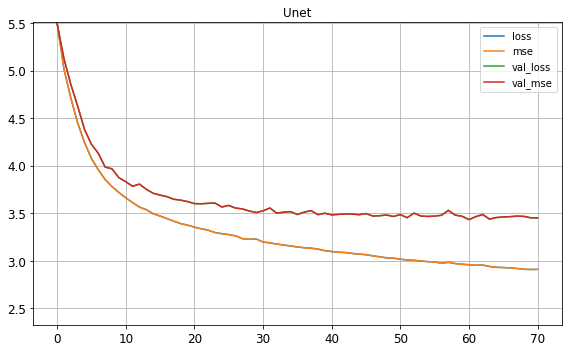

INFO:tensorflow:Assets written to: tmp/prec_UNET1_724b2171247e6d5cf96b49a2716c9044/assets


INFO:tensorflow:Assets written to: tmp/prec_UNET1_724b2171247e6d5cf96b49a2716c9044/assets


69/69 [==============================] - 1s 11ms/step
Plotting results of the training period.


/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software.el7/software/Anaconda

Plotting results of the testing period.


/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software.el7/software/Anaconda3/2021.11-foss-2021a/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/software.el7/software/Anaconda

ValueError: not enough values to unpack (expected 4, got 1)

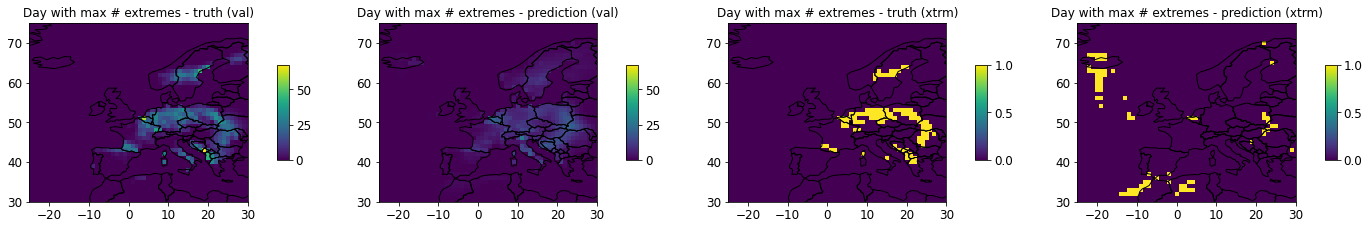

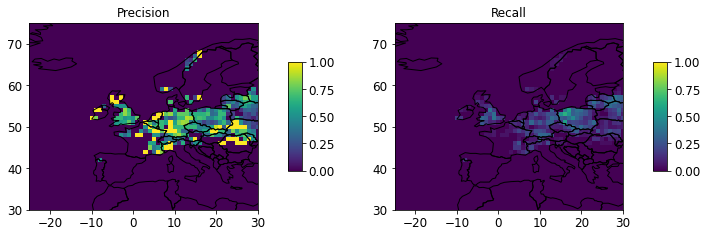

In [31]:
# Predict the amount of precipitation
df_prec = pd.DataFrame(columns = ['id', 'name', 'n_params', 'opt_model', 'opt_optimizer',
                                  'train_pr_rmse', 'test_pr_rmse', 
                                  'train_xtrm_precision', 'test_xtrm_precision', 
                                  'train_xtrm_recall', 'test_xtrm_recall'])
df_xtrm = pd.DataFrame(columns = ['id', 'name', 'n_params', 'opt_model', 'opt_optimizer',
                                  'train_xtrm_roc_auc', 'test_xtrm_roc_auc', 
                                  'train_xtrm_precision', 'test_xtrm_precision', 
                                  'train_xtrm_recall', 'test_xtrm_recall'])

train_for_prec = True
train_for_xtrm = True
history_log_level = 1

models_prec = []
models_xtrm = []

if train_for_prec:
        
    for m_id in models:
        # Clear session and set tf seed
        keras.backend.clear_session()
        tf.random.set_seed(42)
        
        if not models[m_id]['run']:
            continue

        # Extract model name and options
        model = models[m_id]['model']
        opt_model_i = models[m_id]['opt_model']
        opt_optimizer_i = models[m_id]['opt_optimizer']
        opt_model_new = opt_model.copy()
        opt_model_new.update(opt_model_i)
        opt_optimizer_new = opt_optimizer.copy()
        opt_optimizer_new.update(opt_optimizer_i)
        print(f'Running: {m_id} - {model} - {opt_model_i} - {opt_optimizer_i}')
        df_prec = df_prec.append({'id': m_id, 'name': model, 'opt_model': opt_model_i, 'opt_optimizer': opt_optimizer_i}, ignore_index=True)

        # Switch to precipitation values
        dg_train.for_extremes(False)
        dg_valid.for_extremes(False)
        dg_test.for_extremes(False)
        
        optimizer = initiate_optimizer(**opt_optimizer_new)

        # Load if previously saved
        tag = pickle.dumps(opt_model_new) + pickle.dumps(opt_optimizer_new) + \
            pickle.dumps(i_shape + o_shape) + pickle.dumps(PRECIP_XTRM)
        hashed_name = f'prec_{m_id}_{hashlib.md5(tag).hexdigest()}'
        tmp_file = pathlib.Path(f'tmp/{hashed_name}')
        
        if tmp_file.exists():
            m = keras.models.load_model(tmp_file)
            
        else:
            # Create the model and compile
            m = DeepFactory(model, i_shape, o_shape, for_extremes=False, **opt_model_new)
            # Warning: When using regularizers, the loss function is the entire loss, ie (loss metrics) + (regularization term)!
            # But the loss displayed as part of the metrics, is only the loss metric. The regularization term is not added there. -> can be different!!
            m.compile(
                loss='mse', 
                metrics=['mse'], 
                optimizer=optimizer
            )
            print(f'Number of parameters: {m.model.count_params()}')

            # Train
            hist = m.fit(dg_train, validation_data=dg_valid, verbose=history_log_level, **opt_training)
            
            # Plot training evolution
            pd.DataFrame(hist.history).plot(figsize=(8, 5))
            ymin = 0.8 * min([min(hist.history['loss']), min(hist.history['val_loss']), min(hist.history['mse'])])
            ymax = min(max(max(hist.history['loss']), max(hist.history['val_loss'])), 
                       2 * max(sum(hist.history['loss'])/len(hist.history['loss']), sum(hist.history['val_loss'])/len(hist.history['val_loss'])))
            plt.ylim(ymin, ymax)
            plt.grid(True)
            plt.title(model)
            plt.tight_layout()
            now = datetime.datetime.now()
            plt.savefig(f'figures/training_prec_{m_id}_{now.strftime("%Y-%m-%d_%H-%M-%S")}.pdf')
            plt.savefig(f'figures/training_prec_{m_id}_{now.strftime("%Y-%m-%d_%H-%M-%S")}.png')
            plt.show()

            # Saving the model
            m.save(f'tmp/{hashed_name}')
        
        df_prec.at[df_prec.index[-1], 'n_params'] = m.model.count_params()
        models_prec.append(m)
        
        # Predict and save scores
        y_pred_train = m.predict(dg_train.X.to_numpy()).squeeze()
        y_pred_test = m.predict(dg_test.X.to_numpy()).squeeze()
        df_prec.at[df_prec.index[-1], 'train_pr_rmse'] = np.sqrt(np.square(np.subtract(dg_train.y.to_numpy().squeeze(), y_pred_train)).mean())
        df_prec.at[df_prec.index[-1], 'test_pr_rmse'] =  np.sqrt(np.square(np.subtract(dg_test.y.to_numpy().squeeze(), y_pred_test)).mean())
        
        # Analyze predictions
        print('Plotting results of the training period.')
        precision, recall = analyze_predictions(y_pred_train, dg_train, qq, pred_xtrm=False, show_plots=False)
        df_prec.at[df_prec.index[-1], 'train_xtrm_precision'] = precision
        df_prec.at[df_prec.index[-1], 'train_xtrm_recall'] = recall
        plt.show()
        
        print('Plotting results of the testing period.')
        precision, recall = analyze_predictions(y_pred_test, dg_test, qq, pred_xtrm=False)
        df_prec.at[df_prec.index[-1], 'test_xtrm_precision'] = precision
        df_prec.at[df_prec.index[-1], 'test_xtrm_recall'] = recall
        plt.show()
    
        print(df_prec.iloc[-1])
        
        print(f"\n{'*' * 100}\n")
        
if train_for_xtrm:

    for m_id in models:
        # Clear session and set tf seed
        keras.backend.clear_session()
        tf.random.set_seed(42)

        if not models[m_id]['run']:
            continue
        
        # Extract model name and options
        model = models[m_id]['model']
        opt_model_i = models[m_id]['opt_model']
        opt_optimizer_i = models[m_id]['opt_optimizer']
        opt_model_new = opt_model.copy()
        opt_model_new.update(opt_model_i)
        opt_optimizer_new = opt_optimizer.copy()
        opt_optimizer_new.update(opt_optimizer_i)
        print(f'Running: {m_id} - {model} - {opt_model_i} - {opt_optimizer_i}')
        df_xtrm = df_xtrm.append({'id': m_id, 'name': model, 'opt_model': opt_model_i, 'opt_optimizer': opt_optimizer_i}, ignore_index=True)
        
        # Switch to precipitation extremes
        dg_train.for_extremes(True)
        dg_valid.for_extremes(True)
        dg_test.for_extremes(True)
        
        optimizer = initiate_optimizer(**opt_optimizer_new)
        
        # Load if previously saved
        tag = pickle.dumps(opt_model_new) + pickle.dumps(opt_optimizer_new) + \
            pickle.dumps(i_shape + o_shape) + pickle.dumps(PRECIP_XTRM)
        hashed_name = f'xtrm_{m_id}_{hashlib.md5(tag).hexdigest()}'
        tmp_file = pathlib.Path(f'tmp/{hashed_name}')
        
        if tmp_file.exists():
            custom_objects = {"weighted_cross_entropy_fn": weighted_binary_cross_entropy}
            with keras.utils.custom_object_scope(custom_objects):
                m = keras.models.load_model(tmp_file)
            
        else:
            # Create the model and compile
            m = DeepFactory(model, i_shape, o_shape, for_extremes=True, **opt_model_new)
            m.compile(
                loss=xtrm_loss,
                optimizer=optimizer
            )
            print(f'Number of parameters: {m.model.count_params()}')

            # Train
            hist = m.fit(dg_train, validation_data=dg_valid, verbose=history_log_level, **opt_training)
            
            # Plot training evolution
            pd.DataFrame(hist.history).plot(figsize=(8, 5))
            ymin = 0.8 * min([min(hist.history['loss']), min(hist.history['val_loss'])])
            ymax = min(max(max(hist.history['loss']), max(hist.history['val_loss'])), 
                       2 * max(sum(hist.history['loss'])/len(hist.history['loss']), sum(hist.history['val_loss'])/len(hist.history['val_loss'])))
            plt.ylim(ymin, ymax)
            plt.grid(True)
            plt.title(model)
            plt.tight_layout()
            now = datetime.datetime.now()
            plt.savefig(f'figures/training_xtrm_{m_id}_{now.strftime("%Y-%m-%d_%H-%M-%S")}.pdf')
            plt.savefig(f'figures/training_xtrm_{m_id}_{now.strftime("%Y-%m-%d_%H-%M-%S")}.png')
            plt.show()

            # Saving the model
            m.save(f'tmp/{hashed_name}')
        
        df_xtrm.at[df_xtrm.index[-1], 'n_params'] = m.model.count_params()
        models_xtrm.append(m)
        
        # Assess and save scores
        y_pred_train = m.predict(dg_train.X.to_numpy()).squeeze()
        y_pred_test = m.predict(dg_test.X.to_numpy()).squeeze()
        
        # Analyze predictions
        print('Plotting results of the training period.')
        precision, recall, roc_auc = analyze_predictions(y_pred_train, dg_train, qq, pred_xtrm=True, show_plots=False)
        df_xtrm.at[df_xtrm.index[-1], 'train_xtrm_precision'] = precision
        df_xtrm.at[df_xtrm.index[-1], 'train_xtrm_recall'] = recall
        df_xtrm.at[df_xtrm.index[-1], 'train_xtrm_roc_auc'] = roc_auc
        plt.show()
        
        print('Plotting results of the testing period.')
        precision, recall, roc_auc = analyze_predictions(y_pred_test, dg_test, qq, pred_xtrm=True)
        df_xtrm.at[df_xtrm.index[-1], 'test_xtrm_precision'] = precision
        df_xtrm.at[df_xtrm.index[-1], 'test_xtrm_recall'] = recall
        df_xtrm.at[df_xtrm.index[-1], 'test_xtrm_roc_auc'] = roc_auc
        plt.show()

        print(df_xtrm.iloc[-1])
        
        print(f"\n{'*' * 100}\n")

In [ ]:
df_prec

In [ ]:
df_xtrm

In [ ]:
# Plotting
n_models = 0
for m_id in models:
    if models[m_id]['run']:
        n_models += 1
        
n_rows = n_models+1
fig, axs = plt.subplots(n_rows, 3, figsize=(10, n_rows*3))

# Extract true values
y_xtrm = dg_test.y_xtrm.to_numpy().squeeze()
y_prec = dg_test.y.to_numpy().squeeze()

# Get the index of the max # of extremes
i_max_obs = np.argmax(np.sum(y_xtrm, axis=(1,2)))

vmax = np.max(y_prec[i_max_obs])

plot_map(axs[0, 0], lons_y, lats_y, y_prec[i_max_obs], title="Prec. value - truth", vmin=0, vmax=vmax, show_colorbar=False, cmap=mpl.cm.YlGnBu)
plot_map(axs[0, 1], lons_y, lats_y, y_xtrm[i_max_obs], title="Prec. extreme - truth", vmin=0, vmax=1, show_colorbar=False)
plot_map(axs[0, 2], lons_y, lats_y, y_xtrm[i_max_obs], title="Prec. extreme - truth", vmin=0, vmax=1, show_colorbar=False)
    
for idx, m_id in enumerate(models):

    if not models[m_id]['run']:
        continue

    # Precip value - extract model name and options
    model = models[m_id]['model']
    opt_model_i = models[m_id]['opt_model']
    opt_optimizer_i = models[m_id]['opt_optimizer']
    opt_model_new = opt_model.copy()
    opt_model_new.update(opt_model_i)
    opt_optimizer_new = opt_optimizer.copy()
    opt_optimizer_new.update(opt_optimizer_i)
    print(f'Plotting: {m_id} - {model} - {opt_model_i} - {opt_optimizer_i}')

    # Switch to precipitation values
    dg_test.for_extremes(False)

    # Load if previously saved
    tag = pickle.dumps(opt_model_new) + pickle.dumps(opt_optimizer_new) + \
        pickle.dumps(i_shape + o_shape) + pickle.dumps(PRECIP_XTRM)
    hashed_name = f'prec_{m_id}_{hashlib.md5(tag).hexdigest()}'
    tmp_file = pathlib.Path(f'tmp/{hashed_name}')

    m = keras.models.load_model(tmp_file)

    # Predict and save scores
    y_pred = m.predict(dg_test.X[i_max_obs:i_max_obs+2].to_numpy()).squeeze()
    
    y_pred_bool = y_pred > qq.to_numpy().squeeze()

    # Multiply to transorm to numeric values
    y_pred_bool = y_pred_bool * 1
    
    plot_map(axs[idx+1, 0], lons_y, lats_y, y_pred[0], title=f"Prec. value - {m_id}", vmin=0, vmax=vmax, show_colorbar=False, cmap=mpl.cm.YlGnBu)
    plot_map(axs[idx+1, 1], lons_y, lats_y, y_pred_bool[0], title=f"Prec. extreme - {m_id}", vmin=0, vmax=1, show_colorbar=False)

    # Preci extremes - extract model name and options
    model = models[m_id]['model']
    opt_model_i = models[m_id]['opt_model']
    opt_optimizer_i = models[m_id]['opt_optimizer']
    opt_model_new = opt_model.copy()
    opt_model_new.update(opt_model_i)
    opt_optimizer_new = opt_optimizer.copy()
    opt_optimizer_new.update(opt_optimizer_i)
    print(f'Plotting: {m_id} - {model} - {opt_model_i} - {opt_optimizer_i}')

    # Switch to precipitation extremes
    dg_test.for_extremes(True)

    # Load if previously saved
    tag = pickle.dumps(opt_model_new) + pickle.dumps(opt_optimizer_new) + \
        pickle.dumps(i_shape + o_shape) + pickle.dumps(PRECIP_XTRM)
    hashed_name = f'xtrm_{m_id}_{hashlib.md5(tag).hexdigest()}'
    tmp_file = pathlib.Path(f'tmp/{hashed_name}')

    custom_objects = {"weighted_cross_entropy_fn": weighted_binary_cross_entropy}
    with keras.utils.custom_object_scope(custom_objects):
        m = keras.models.load_model(tmp_file)

    # Assess and save scores
    y_pred_xtrm = m.predict(dg_test.X[i_max_obs:i_max_obs+2].to_numpy()).squeeze()

    plot_map(axs[idx+1, 2], lons_y, lats_y, y_pred_xtrm[0], title=f"Prec. extreme - {m_id}", vmin=0, vmax=1, show_colorbar=False)

plt.tight_layout()
plt.savefig('figures/plot_model_comparison.pdf')